# Spectroscopic Eigensolver with Sampler

This tutorial demonstrates the ability to send flexible circuits to the `Sampler` primitive by performing a simple example of the spectroscopic eigensolver algorithm ([arXiv:2202.12910](http://arxiv.org/abs/2202.12910)). The SEA is used for quantum simulation of model Hamiltonians, and works by interacting a "probe" auxiliary qubit with a simulation register. The energy of the probe qubit is sweeped and its properties of the simulation Hamiltonian are observed as peaks or dips in the response, akin to the experimental tool of spectroscopy. Because each point (i.e., energy) is a different quantum circuit, this technique is expensive with respect to the number of circuits required. The `Sampler` provides the flexibility to send just a single circuit with the needed `Parameter`s passed.

In [1]:
# load necessary Runtime libraries
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

## Simple Hamiltonian Model

Let's consider a Pauli-X matrix acting on a qubit,
$$
H_{\rm Pauli} = \mu \sigma_1^x = \mu X
$$
where we can set $\mu$ later, or even sweep its values as well. The SEA works by taking the model Pauli (i.e., qubit) Hamiltonian and building a larger "resonance" Hamiltonian that includes both the simulation register and probe qubit `q0` via
$$
H_{\rm res} / \hbar = -\frac{1}{2} \omega IZ + c XX + H_{\rm Pauli} \otimes I
$$
where the angular frequency $\omega$ corresponds to the energy of the probe qubit, and $c$ is the coupling between the probe qubit and a qubit in the simulation register (`q1` in this case). The letters $I$, $X$, and $Z$ correspond to the Pauli spin matrices and their order reflect which qubit they operate on. 

We can construct the SEA circuits with tools from Qiskit Oplow.

In [47]:
from qiskit.circuit import Parameter
from qiskit.opflow import I, X, Z

mu = Parameter('$\\mu$')
ham_pauli = mu * X

In [54]:
cc = Parameter('$c$')
ww = Parameter('$\\omega$')

ham_res = -(1/2)*ww*(I^Z) + cc*(X^X) + (ham_pauli^I)

Time evolve the resonance Hamiltonian.

In [49]:
tt = Parameter('$t$')
U_ham = (tt*ham_res).exp_i()
#print(U_ham)

e^(-i*1.0*$dt$ * SummedOp([
  -0.5*$\omega$ * IZ,
  1.0*$c$ * XX,
  1.0*$\mu$ * XI
]))


From the time-evolution operator $U_{\rm ham}$, we use the Suzuki-Trotter expansion to convert this operator into quantum circuits that implement discrete time steps of the simulation. The smaller the time steps (more Trotter steps), the more accurate the quantum circuit, but also longer depth, which could introduce errors when executing on noisy quantum hardware. We then transpiler the circuits to IBM backend basis gates and measure only the probe qubit `q0`.

In [53]:
from qiskit import transpile
from qiskit.circuit import ClassicalRegister
from qiskit.opflow import PauliTrotterEvolution, Suzuki
import numpy as np

num_trot_steps = 2
total_time = 6
cr = ClassicalRegister(1, 'c')

spec_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=num_trot_steps)).convert(U_ham)
spec_circ = spec_op.to_circuit()
spec_circ_t = transpile(spec_circ, basis_gates=['sx', 'rz', 'cx'])
spec_circ_t.add_register(cr)
spec_circ_t.measure(0, cr[0])

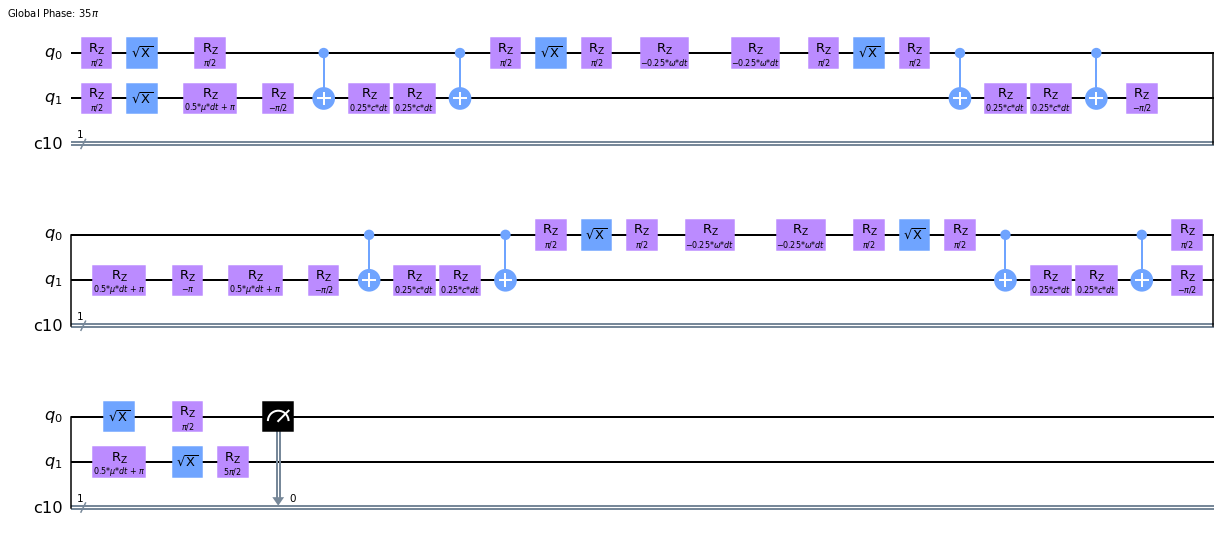

In [40]:
spec_circ_t.draw('mpl')

Now let's fix our parameters and sweep over frequency. Let's do num points, TODO

Note that the `Parameter`s' keys and values must be separared and converted into a `List` of `List`s. The keys give us the `Parameter`s inside each circuit. In this case, we only have a single circuit, so the `List` of keys contains a single `List`. For the `Parameter` values, there is a `List` for each value of `ww`. 

In [42]:
param_bind = {
    cc: 0.3,
    mu: 0.7,
    tt: total_time
}
param_keys = [list(param_bind.keys()) + [ww]]

num_pts = 101
wvals = np.linspace(-3.5, 3.5, num_pts)
param_vals = [list(param_bind.values()) + [wval] for wval in wvals]

In the `Sampler` class, we pass the list of circuits and parameter keys in the constructor. When calling the `sampler`, we specify a list of `circuit_indices` pointing to the circuits desired to be run (which was passed to the constructor), in this case, the index `0` `num_pts` times.

In [45]:
with Sampler(
        service=QiskitRuntimeService(),
        circuits=[spec_circ_t], 
        parameters=param_keys,
        skip_transpilation=True) as sampler:
    result = sampler(
            circuit_indices=[0]*num_pts, 
            parameter_values=param_vals
        )

SamplerResult(quasi_dists=[{'1': 0.3515625, '0': 0.6484375}, {'1': 0.3037109375, '0': 0.6962890625}, {'0': 0.73046875, '1': 0.26953125}, {'1': 0.212890625, '0': 0.787109375}, {'1': 0.1845703125, '0': 0.8154296875}, {'1': 0.150390625, '0': 0.849609375}, {'1': 0.1259765625, '0': 0.8740234375}, {'0': 0.896484375, '1': 0.103515625}, {'1': 0.0732421875, '0': 0.9267578125}, {'1': 0.0517578125, '0': 0.9482421875}, {'1': 0.0478515625, '0': 0.9521484375}, {'1': 0.025390625, '0': 0.974609375}, {'1': 0.017578125, '0': 0.982421875}, {'1': 0.0078125, '0': 0.9921875}, {'1': 0.0068359375, '0': 0.9931640625}, {'1': 0.0009765625, '0': 0.9990234375}, {'1': 0.001953125, '0': 0.998046875}, {'0': 1.0}, {'0': 1.0}, {'0': 1.0}, {'0': 1.0}, {'0': 1.0}, {'0': 1.0}, {'0': 1.0}, {'1': 0.001953125, '0': 0.998046875}, {'1': 0.0009765625, '0': 0.9990234375}, {'1': 0.001953125, '0': 0.998046875}, {'1': 0.00390625, '0': 0.99609375}, {'1': 0.0146484375, '0': 0.9853515625}, {'1': 0.0185546875, '0': 0.9814453125}, {'1':

In [57]:
Zexps = []
for idx, dist in enumerate(result.quasi_dists):
    if '0' in dist:
        Zexps.append(1 - 2*dist['0'])

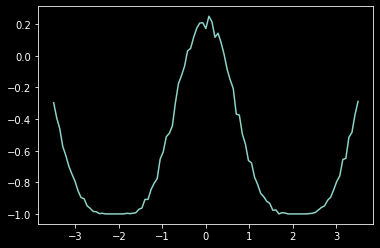

In [66]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

fig, ax = plt.subplots()
ax.plot(wvals, Zexps)

In [ ]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

In [ ]:
from qiskit.tools.jupyter import *
%qiskit_version_table